In [21]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV


from sklearn.metrics import balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

SEED = 42
np.random.seed(SEED)

In [22]:
df = pd.read_csv('../data/df_cleaned.csv').drop(columns=['TENSE/ANXIOUS']) # Analitzarem nomes el TIRED


print(f"Shape: {df.shape}")

print(f'Columnes: \n{df.columns.tolist()}')

Shape: (7410, 24)
Columnes: 
['nightly_temperature', 'nremhr', 'rmssd', 'spo2', 'full_sleep_breathing_rate', 'stress_score', 'daily_temperature_variation', 'calories', 'bpm', 'sedentary_minutes', 'resting_hr', 'minutesAsleep', 'minutesAwake', 'sleep_efficiency', 'sleep_deep_ratio', 'sleep_wake_ratio', 'sleep_light_ratio', 'sleep_rem_ratio', 'steps', 'age', 'gender', 'bmi', 'TIRED', 'bmi_tipo']


Balance TIRED:
TIRED
0.0    61.57
1.0    38.43
Name: %, dtype: float64


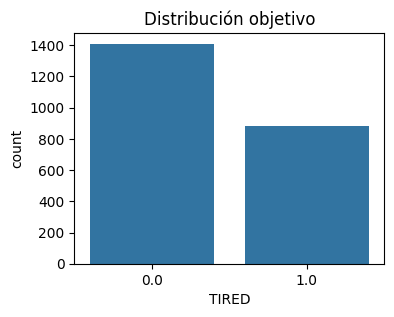

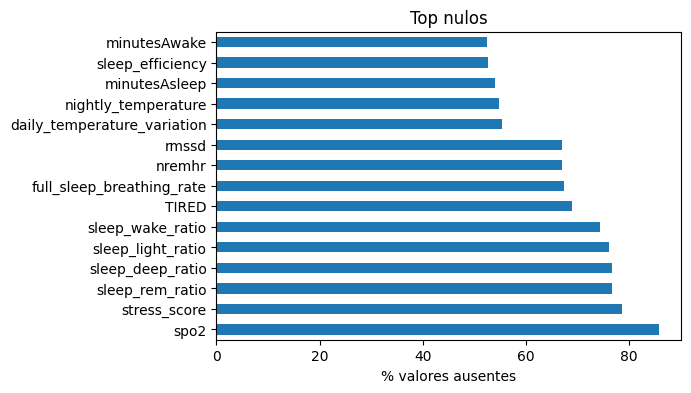

bmi                            0.111665
stress_score                   0.105203
calories                       0.087870
full_sleep_breathing_rate      0.082635
minutesAsleep                  0.078461
sleep_deep_ratio               0.078229
daily_temperature_variation    0.063206
steps                          0.059260
sleep_light_ratio              0.047110
sleep_rem_ratio                0.044766
dtype: float64


In [23]:
"""
## 2. EDA Rápida
"""
# %%
print("Balance TIRED:")
print(df['TIRED'].value_counts(normalize=True).rename('%').mul(100).round(2))

plt.figure(figsize=(4,3))
sns.countplot(x='TIRED', data=df)
plt.title('Distribución objetivo')
plt.show()

# Missing values
miss = df.isna().mean().sort_values(ascending=False)*100
plt.figure(figsize=(6,4))
miss.head(15).plot(kind='barh')
plt.xlabel('% valores ausentes')
plt.title('Top nulos')
plt.show()

# Correlaciones numéricas rápidas
num_cols = df.select_dtypes(include=['number']).columns.drop('TIRED')
corr = df[num_cols].corrwith(df['TIRED'], method='spearman').abs().sort_values(ascending=False)[:10]
print(corr)


In [24]:
# Variables a descartar por >50% nulos
DROP_VARS = ['spo2', 'stress_score']
df = df.drop(columns=DROP_VARS)

# Separar features/target
y = df['TIRED']
X = df.drop(columns=['TIRED'])

# Identificar tipos
def get_col_types(df):
    num = df.select_dtypes(include=['number']).columns.tolist()
    cat = df.select_dtypes(exclude=['number']).columns.tolist()
    return num, cat

num_cols, cat_cols = get_col_types(X)

In [25]:
# Pipelines
numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, num_cols),
    ('cat', categorical_pipe, cat_cols)
])

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, class_weight='balanced_subsample')
pipe_rf = Pipeline(steps=[('preprocess', preprocess),
                         ('model', rf)])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_test)
y_proba_rf = pipe_rf.predict_proba(X_test)[:,1]
metrics_rf = {m: round(v,3) for m,v in zip(['Accuracy','Precision','Recall','F1','ROC_AUC'],
                                       [accuracy_score(y_test, y_pred_rf),
                                        precision_score(y_test, y_pred_rf),
                                        recall_score(y_test, y_pred_rf),
                                        f1_score(y_test, y_pred_rf),
                                        roc_auc_score(y_test, y_proba_rf)])}
metrics_rf


NameError: name 'preprocess' is not defined